## 10 Analysis

In [68]:
# Import packages
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm as CM
from matplotlib import mlab as ML
import pandas as pd
import numpy as np
import itertools
from scipy import stats
from scipy.stats import poisson
from scipy.stats import lognorm
from decimal import *
from mpl_toolkits.mplot3d import Axes3D
from pylab import *
import sklearn.mixture
import scipy.stats as ss
import seaborn as sns

# Read in data
df = pd.read_csv('../output.csv')

### (1) Cut out the edges and plot the 2-D synapses density

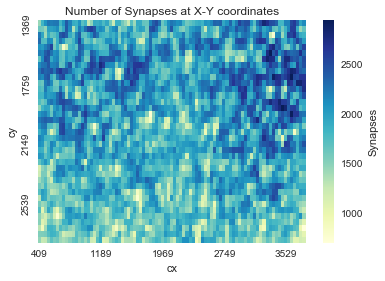

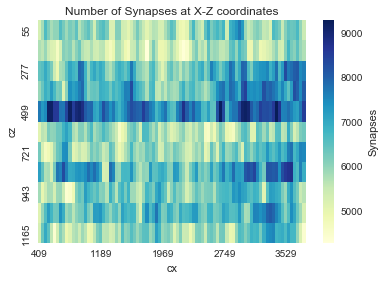

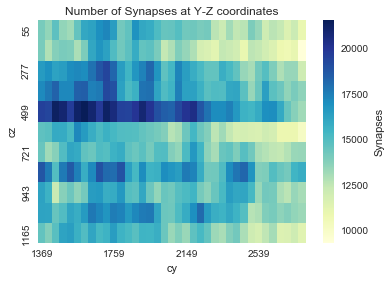

In [69]:
nvox = 64*64*48
dfcut = df[(df['cx'] > 400) & (df['cx'] < 3800) & (df['cy'] < 2800)]
dfftr = dfcut[dfcut['unmasked'] > nvox * 0.5]

sumXY = pd.pivot_table(dfftr, index='cy', columns='cx', values='synapses', aggfunc=np.sum)
sumXZ = pd.pivot_table(dfftr, index='cz', columns='cx', values='synapses', aggfunc=np.sum)
sumYZ = pd.pivot_table(dfftr, index='cz', columns='cy', values='synapses', aggfunc=np.sum)

import seaborn as sns

plt.figure()
sns.heatmap(sumXY, xticklabels=20, yticklabels=10, cbar_kws={'label': 'Synapses'}, cmap="YlGnBu");
plt.title('Number of Synapses at X-Y coordinates');

plt.figure()
sns.heatmap(sumXZ, xticklabels=20, yticklabels=2, cbar_kws={'label': 'Synapses'}, cmap="YlGnBu");
plt.title('Number of Synapses at X-Z coordinates');

plt.figure()
sns.heatmap(sumYZ, xticklabels=10, yticklabels=2, cbar_kws={'label': 'Synapses'}, cmap="YlGnBu");
plt.title('Number of Synapses at Y-Z coordinates');

## (2) 3D plot of new data set

C:\Users\Tri\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


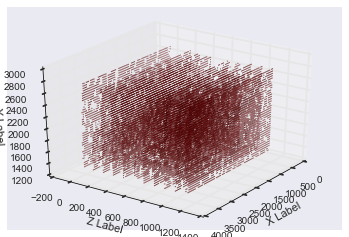

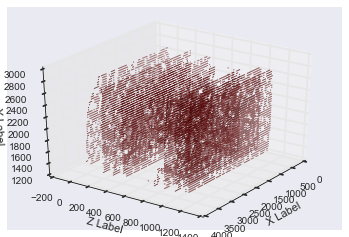

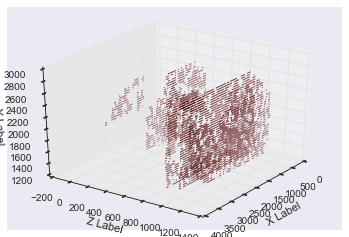

In [105]:
nvox = 64 * 64 * 48
dfcut['weighted'] = dfcut['synapses'] / dfcut['unmasked'] * nvox
dfthr = dfcut[dfcut['unmasked'] > nvox * 0.5]

k = [0.7, 0.75, 0.8]
for j in k:
    dfweg = dfcut[dfcut['unmasked'] > nvox * j] # Thresholded data frame
    fig = plt.figure()
    ax = fig.add_subplot(111, projection = '3d')
    c = 'r'
    m = '8'
    xs = dfweg['cx']
    ys = dfweg['cy']
    zs = dfweg['cz'] 
    ax.scatter(xs, zs, ys, c=c, marker = m, s = 0.65)
    ax.set_xlabel('X Label')
    ax.set_ylabel('Z Label')
    ax.set_zlabel('Y Label')
    ax.view_init(azim = 35)
    fig.show()

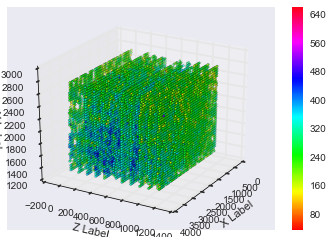

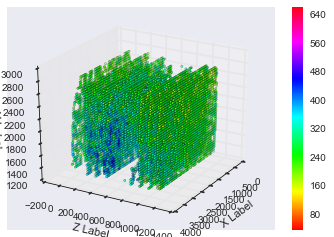

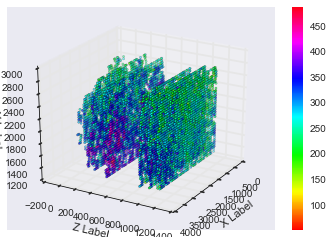

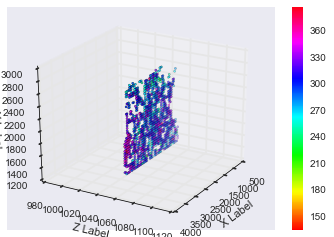

In [106]:
for i in ([0.7, 0.75, 0.78, 0.82]):
    dfweg = dfcut[dfcut['unmasked'] > nvox * i] # Thresholded data frame
    fig = plt.figure(figsize=(6, 4))

    ax = fig.add_subplot(111, projection='3d')
    xs = dfweg['cx']
    ys = dfweg['cy']
    zs = dfweg['cz'] 
    the_fourth_dimension = dfweg['weighted']

    colors = cm.hsv(the_fourth_dimension/max(the_fourth_dimension))

    colmap = cm.ScalarMappable(cmap=cm.hsv)
    colmap.set_array(the_fourth_dimension)
    m = '8'
    yg = ax.scatter(xs, zs, ys, c = colors, marker = m, s  = 5)
    cb = fig.colorbar(colmap)

    ax.set_xlabel('X Label')
    ax.set_ylabel('Z Label')
    ax.set_zlabel('Y Label')
    ax.view_init(elev = 25, azim = 30)

    plt.show()

It basically tell us that the higher synapses accumulated in such Z-layer, not randomly distributed.

## (3)Uniform distribution in the whole data set

In [19]:
sample = dfthr['weighted']

m = 8 # bin number
boundary = np.linspace(100, 500, m + 1)

exp_freq = len(sample) / 10

bin_content = []
for i in boundary:
    bin_content = np.append(bin_content, sum(sample <= i))
                          
obe_freq = []
for i in range(0, m + 1):
    if i == 0:
        obe_freq = np.append(obe_freq, bin_content[i])
    if i > 0:
        obe_freq = np.append(obe_freq, bin_content[i] - bin_content[i - 1])
         
observed_values = obe_freq

test_value = stats.chisquare(observed_values, f_exp = exp_freq)[1]

print test_value

0.0


Since p-value is nearly 0.0, it strongly rejects the null hypothesis that the new data set follows uniform distribution.

## (4) one-way ANOVA by Z-layer

In [32]:
arr_z = []

for i in range(0, 6):
    arr_z.append(dfthr[dfthr['cz'] == dfthr['cz'].unique()[i]]['weighted'])

stats.f_oneway(arr_z[0],arr_z[1],arr_z[2],arr_z[3],arr_z[4],arr_z[5])

F_onewayResult(statistic=368.24957207690682, pvalue=0.0)

Since p-value is nearly 0, it suggests that the mean of synapses are not equal in each Z-layer.

## (5) Normal distribution assumption in Z-layer

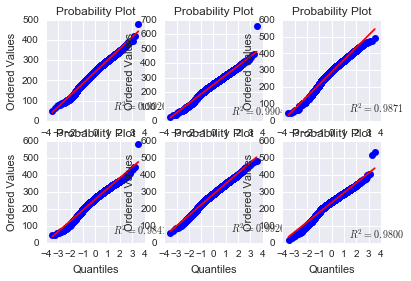

In [33]:
for i, j in zip(range(0, 6), [231, 232, 233, 234, 235, 236]):
    ax = plt.subplot(j)
    x = arr_z[i]
    res = stats.probplot(x, plot = plt)

Check the assumption of ANOVA, it suggests that the synapses in each Z-layer are normally distributed.

## (6) Aggregated Y into 4 layers and do one-way ANOVA

In [126]:
scy = sorted(dfthr['cy'].unique())

sy1 = dfthr[(dfthr['cy'] >= scy[0]) & (dfthr['cy'] <= scy[9])]
sy2 = dfthr[(dfthr['cy'] >= scy[9]) & (dfthr['cy'] <= scy[19])]
sy3 = dfthr[(dfthr['cy'] >= scy[19]) & (dfthr['cy'] <= scy[29])]
sy4 = dfthr[(dfthr['cy'] >= scy[29]) & (dfthr['cy'] <= scy[36])]
    
print(stats.f_oneway(sy1['weighted'], sy2['weighted'], sy3['weighted'], sy4['weighted']))
print 
yset = [sy1, sy2, sy3, sy4]

for i in range(0, 4):
    print "Variance of layer %d is: %d" % (i+1, np.var(yset[i]['weighted']))
    print "Mean of layer %d is: %7d" % (i+1, np.average(yset[i]['weighted']))


F_onewayResult(statistic=886.47925998354947, pvalue=0.0)

Variance of layer 1 is: 4481
Mean of layer 1 is:     271
Variance of layer 2 is: 4340
Mean of layer 2 is:     263
Variance of layer 3 is: 3804
Mean of layer 3 is:     245
Variance of layer 4 is: 3455
Mean of layer 4 is:     224


Since the p-value are nearly 0, it suggests that the mean synapses are not the same in each Y-layer.

## (7) Pairwised t-test in 4 Y-layers

In [46]:
print stats.ttest_ind(sy1['weighted'], sy2['weighted'], equal_var = True)
print stats.ttest_ind(sy1['weighted'], sy3['weighted'], equal_var = True)
print stats.ttest_ind(sy1['weighted'], sy4['weighted'], equal_var = True)
print stats.ttest_ind(sy2['weighted'], sy3['weighted'], equal_var = True)
print stats.ttest_ind(sy2['weighted'], sy4['weighted'], equal_var = True)
print stats.ttest_ind(sy3['weighted'], sy4['weighted'], equal_var = True)


Ttest_indResult(statistic=8.423479619012161, pvalue=3.9160570086398962e-17)
Ttest_indResult(statistic=28.044919429640036, pvalue=1.465147815226817e-169)
Ttest_indResult(statistic=47.304576326210821, pvalue=0.0)
Ttest_indResult(statistic=19.990375403151237, pvalue=4.9913253116494681e-88)
Ttest_indResult(statistic=40.378974708042719, pvalue=0.0)
Ttest_indResult(statistic=22.771007291529369, pvalue=4.402447471075322e-113)


According to the results, it turns out that each Y-layer are significantly different from each other.

## (8) Clustering in Y-layer

[[ 341.59445057  332.78173654  244.5122314  ...,  153.03616824
   248.18366864  194.12977371]
 [ 247.64326477  134.28968621  279.13290032 ...,  197.65381385
   159.70372074  130.0616659 ]
 [ 313.52990054  271.19743203  274.18959414 ...,  243.70923444
   346.13847387  298.50269424]
 ..., 
 [ 277.73620818  352.84854107  226.92863768 ...,  354.54404198
   189.22810395  271.72789036]
 [ 180.49451895  354.47194941  177.39109678 ...,  123.63364339
   259.52088567  236.0240096 ]
 [ 170.99490893  332.00008305  260.90186117 ...,  237.89620866
   268.56444725  311.38336411]]
Fitting and evaluating model with 1 clusters.
Fitting and evaluating model with 2 clusters.
Fitting and evaluating model with 3 clusters.
Fitting and evaluating model with 4 clusters.
Fitting and evaluating model with 5 clusters.


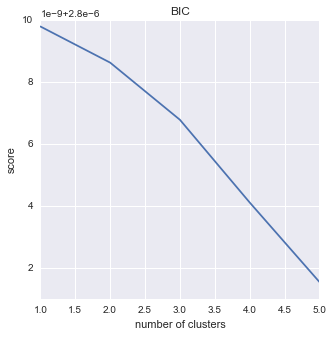

[ 355899.29845653  356047.03681729  356280.92389256  356619.84825926
  356946.24973577]


In [112]:
out = []
Yvalue = np.unique(dfthr['cy'])
minlen = 10000000

for i in Yvalue:
    temp = len(dfthr[dfthr['cy'] == i])
    if temp < minlen:
        minlen = temp
        
for i in Yvalue:
    if i == 1369:
        temp = dfthr[dfthr['cy'] == i]['weighted']
        out = np.random.choice(temp, minlen)
    else :
        temp = dfthr[dfthr['cy'] == i]['weighted']
        sample = np.random.choice(temp, minlen)
        out = np.column_stack((out, sample))

nclusters = range(1, 6)

bic = np.array(())
for idx in nclusters:
    print "Fitting and evaluating model with " + str(idx) + " clusters."
    gmm = sklearn.mixture.GMM(n_components=idx, n_iter=1000, covariance_type = 'diag')
    gmm.fit(out)
    bic = np.append(bic, gmm.bic(out))
plt.figure(figsize=(5, 5))
plt.plot(nclusters, 1.0/bic)
plt.title('BIC')
plt.ylabel('score')
plt.xlabel('number of clusters')
plt.show()
print bic

However, based on the result of clustering, it turns out that Y-layers are identical.

## (9) Use the whole dataset to do clustering

C:\Users\Tri\Anaconda2\lib\site-packages\ipykernel\__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


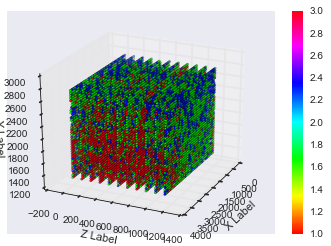

In [107]:
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn import cross_validation
from sklearn.cross_validation import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier

data = dfthr['weighted']

est = KMeans(n_clusters = 3)
est.fit(data.reshape(len(data),1))
labels = est.labels_
dfthr['pred'] = labels + 1

fig = plt.figure(figsize=(6, 4))

ax = fig.add_subplot(111, projection='3d')
xs = dfthr['cx']
ys = dfthr['cy']
zs = dfthr['cz'] 
the_fourth_dimension = dfthr['pred']

colors = cm.hsv(the_fourth_dimension/max(the_fourth_dimension))

colmap = cm.ScalarMappable(cmap=cm.hsv)
colmap.set_array(the_fourth_dimension)
m = '8'
yg = ax.scatter(xs, zs, ys, c = colors, marker = m, s  = 5)
cb = fig.colorbar(colmap)

ax.set_xlabel('X Label')
ax.set_ylabel('Z Label')
ax.set_zlabel('Y Label')
ax.view_init(elev = 25, azim = 25)

plt.show()

## (10) Try using Ordinary Least Square to fit linear model

In [100]:
import statsmodels.api as sm
X = dfthr[['cz','cx','cy']]
y = dfthr['weighted']

X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:               weighted   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     1012.
Date:                Wed, 30 Mar 2016   Prob (F-statistic):               0.00
Time:                        22:49:58   Log-Likelihood:            -1.8322e+05
No. Observations:               32943   AIC:                         3.665e+05
Df Residuals:                   32939   BIC:                         3.665e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        329.8401      2.008    164.266      0.0

In [101]:
norm_x = X.values
for i, name in enumerate(X):
    if name == "const":
        continue
    norm_x[:,i] = X[name]/np.linalg.norm(X[name])
norm_xtx = np.dot(norm_x.T, norm_x)

eigs = np.linalg.eigvals(norm_xtx)
condition_number = np.sqrt(eigs.max() / eigs.min())
print(condition_number)

inf


Obviously, the result is very awful. Synapses density cannot be fitted with regression, at least simple linear regression is not applicable.